In [1]:
# Run deze commands als je het nog niet hebt gedaan
# !pip install opencv-python
# !pip install pillow
# !pip install tensorflow

# Stap 1: Data voorbereiden:
1. Zorg dat je een dataset hebt van ruim meer dan 1000 afbeeldingen
2. Splits de data in 3 datasets:

    a) x_train: ongeveer 80% van de gehele dataset
    
    b) x_test: ongeveer 20% van de gehele dataset
    
    c) x_val: ongeveer 5 afbeeldingen die geen anomally zijn (uit je dataset) + een aantal anomallies
<b> Belangrijk </b>, zorg er voor data je de data _random_ split

3. Zet de afbeeldingen om naar 28 x 28
4. Maak de afbeeldingen zwart wit
5. Maak van elke dataset een numpy object met de shape (aantal_afbeeldingen, 28, 28)

<b> Tip: </b> Kijk even of het is goedgegaan door door je datasets heen te bladeren en afbeeldingen met de "imshow" functie van matplotlib

6. Pixels hebben normaal een waarde tussen 0 en 255, het model werkt alleen met waarden tussen 0 en 1

In [2]:
import cv2
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import os
import random
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# os.chdir("Subsample_image_data")
os.chdir("image_data")

# os.chdir("Subsample_image_data__MACOSX")
# os.chdir("image_data__MACOSX")
os.listdir()

# image_name = '00001_3_F.png'
# image_name

# image = cv2.imread(image_name, cv2.IMREAD_GRAYSCALE)
# # image.shape
# image = Image.fromarray(image)
# image


# # resize de image
# image = np.array((image.resize((28,28), Image.LANCZOS)))
# image.shape


['.DS_Store',
 '00101_1_L.png',
 '00101_1_L.txt',
 '00101_2_F.png',
 '00101_2_F.txt',
 '00101_3_F.png',
 '00101_3_F.txt',
 '00102_1_F.png',
 '00102_1_F.txt',
 '00102_1_R.png',
 '00102_1_R.txt',
 '00102_2_F.png',
 '00102_2_F.txt',
 '00103_1_F.png',
 '00103_1_F.txt',
 '00103_1_L.png',
 '00103_1_L.txt',
 '00103_2_F.png',
 '00103_2_F.txt',
 '00104_1_F.png',
 '00104_1_F.txt',
 '00104_1_R.png',
 '00104_1_R.txt',
 '00104_2_F.png',
 '00104_2_F.txt',
 '00105_1_F.png',
 '00105_1_F.txt',
 '00105_1_R.png',
 '00105_1_R.txt',
 '00105_2_F.png',
 '00105_2_F.txt',
 '00106_1_F.png',
 '00106_1_F.txt',
 '00106_1_R.png',
 '00106_1_R.txt',
 '00106_2_F.png',
 '00106_2_F.txt',
 '00107_1_F.png',
 '00107_1_F.txt',
 '00107_1_R.png',
 '00107_1_R.txt',
 '00107_2_F.png',
 '00107_2_F.txt',
 '00108_1_F.png',
 '00108_1_F.txt',
 '00108_1_R.png',
 '00108_1_R.txt',
 '00108_2_F.png',
 '00108_2_F.txt',
 '00109_1_F.png',
 '00109_1_F.txt',
 '00109_2_F.png',
 '00109_2_F.txt',
 '00109_2_R.png',
 '00109_2_R.txt',
 '00110_1_F.pn

In [3]:
# images in een list zetten
images = []
for image_name in os.listdir():
    if '.png' in image_name:
        image = cv2.imread(image_name, cv2.IMREAD_GRAYSCALE)
        image = Image.fromarray(image)
        image = np.array((image.resize((28,28), Image.LANCZOS)))
        images.append(image)

random.shuffle(images)
images = np.stack(images)

x_val = images[1200:1201] / 255
# x_predict = new_model.predict(x_val)
images.size


898464

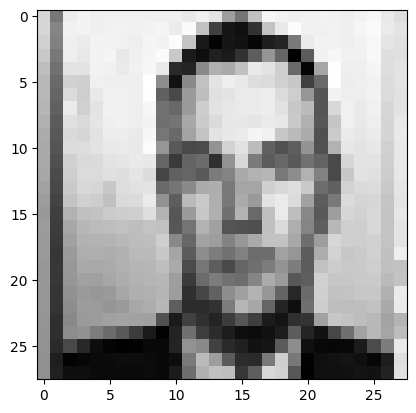

In [4]:
random.shuffle(images)
# er een numpy array van maken in plaats van list
images = np.stack(images)
images.shape


x_train, x_test = train_test_split(images, test_size=0.2, random_state=42)
# Delen door 255 om de waardes tussen 0 en 1 te krijgen
x_train = x_train / 255
x_test = x_test / 255
plt.imshow(images[8], cmap='gray')


In [5]:
def read_img(name):
    image = cv2.imread(name, cv2.IMREAD_GRAYSCALE)
    image = Image.fromarray(image)
    image = image.resize((28, 28), Image.LANCZOS)
    image = np.array(image).astype('float32') / 255.0
    return image

# Stap 2: Het trainen van de Autoencoder
Hieronder krijgen jullie de code van het model (de autoencoder), hij is opgesschreven als functie. In de documentatie van de functie staat wat de inputs en outputs zijn.

In [6]:
def train_autoencoder(x_train, x_test, latent_dim, num_epochs):
    """
    :param x_train: this should be (around) 80% of your train dataset !!important, use a random split
    :param x_test: this should be (around) 20 % of your train dataset !!important, use a random split
    :param latent_dim: This is the space the images will be reduced to, to start: use the value 164, play with it later
    :param num_epochs: The number of training rounds
    :return: [0] : the trained autoencoder model
             [1] : the training data loss per epoch
             [2] : the test data loss per epoch
    """
    import tensorflow as tf
    from tensorflow.keras import layers, losses
    from tensorflow.keras.models import Model

    class Autoencoder(Model):
        def __init__(self, latent_dim):
            super(Autoencoder, self).__init__()
            self.latent_dim = latent_dim
            self.encoder = tf.keras.Sequential([
                layers.Flatten(),
                layers.Dense(latent_dim, activation='relu'),
            ])
            self.decoder = tf.keras.Sequential([
                layers.Dense(784, activation='sigmoid'),
                layers.Reshape((28, 28))
            ])

        def call(self, x):
            encoded = self.encoder(x)
            decoded = self.decoder(encoded)
            return decoded

    autoencoder = Autoencoder(latent_dim)

    autoencoder.compile(optimizer='adam', loss=losses.MeanSquaredError())

    history = autoencoder.fit(x_train, x_train,
                    epochs=num_epochs,
                    shuffle=True,
                    validation_data=(x_test, x_test))

    return autoencoder, history.history['loss'], history.history['val_loss']

## 2.1 Trainen
Train het model met de functie hierboven, kies een lage waarde voor de epochs

In [7]:
model, loss_train, loss_test = train_autoencoder(x_train, x_test, 164, 5)

Epoch 1/5
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0645 - val_loss: 0.0393
Epoch 2/5
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0388 - val_loss: 0.0334
Epoch 3/5
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0333 - val_loss: 0.0305
Epoch 4/5
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0292 - val_loss: 0.0266
Epoch 5/5
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0270 - val_loss: 0.0241


## 2.2 Analyseer de loss functie:
Plot de loss functie en bepaal of je het model lang genoeg getrained hebt

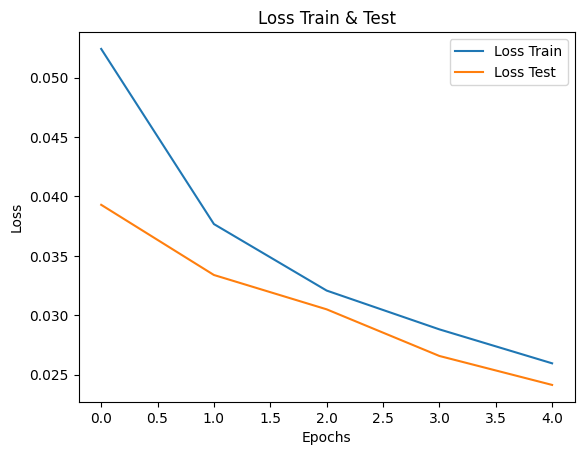

In [8]:
plt.plot(loss_train, label = "Loss Train")
plt.plot(loss_test, label = "Loss Test")
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss Train & Test")
plt.show()

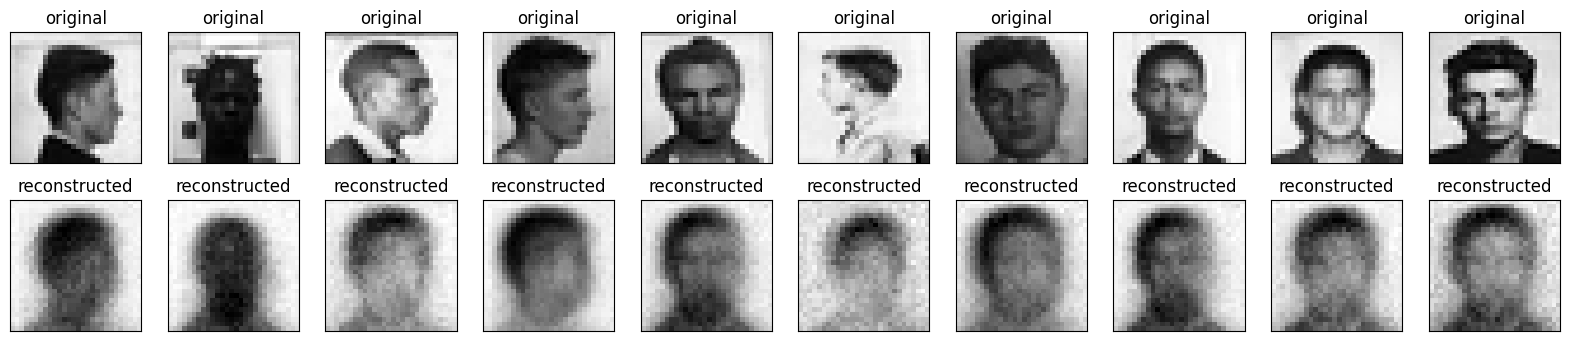

In [9]:
encoded_imgs = model.encoder(x_test).numpy()
decoded_imgs = model.decoder(encoded_imgs).numpy()

n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
  # display original
  ax = plt.subplot(2, n, i + 1)
  plt.imshow(x_test[i])
  plt.title("original")
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

  # display reconstruction
  ax = plt.subplot(2, n, i + 1 + n)
  plt.imshow(decoded_imgs[i])
  plt.title("reconstructed")
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
plt.show()

# Stap 3: Predictions
Gebruik de predict method van het model en stop hier je x_val dataset in.
Plot de originele en gereconstrueerde afbeeldingen en vergelijk ze, zie je verschil met de outliers?

In [10]:
x_val = images[250:255].astype('float32') / 255.0

out1 = read_img("01489_1_F.png")
out2 = read_img("01519_1_F.png")
out3 = read_img("01550_1_R.png")

new_images = np.array([out1, out2, out3])
x_val = np.concatenate((x_val, new_images), axis=0)

x_pred = model.predict(x_val)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


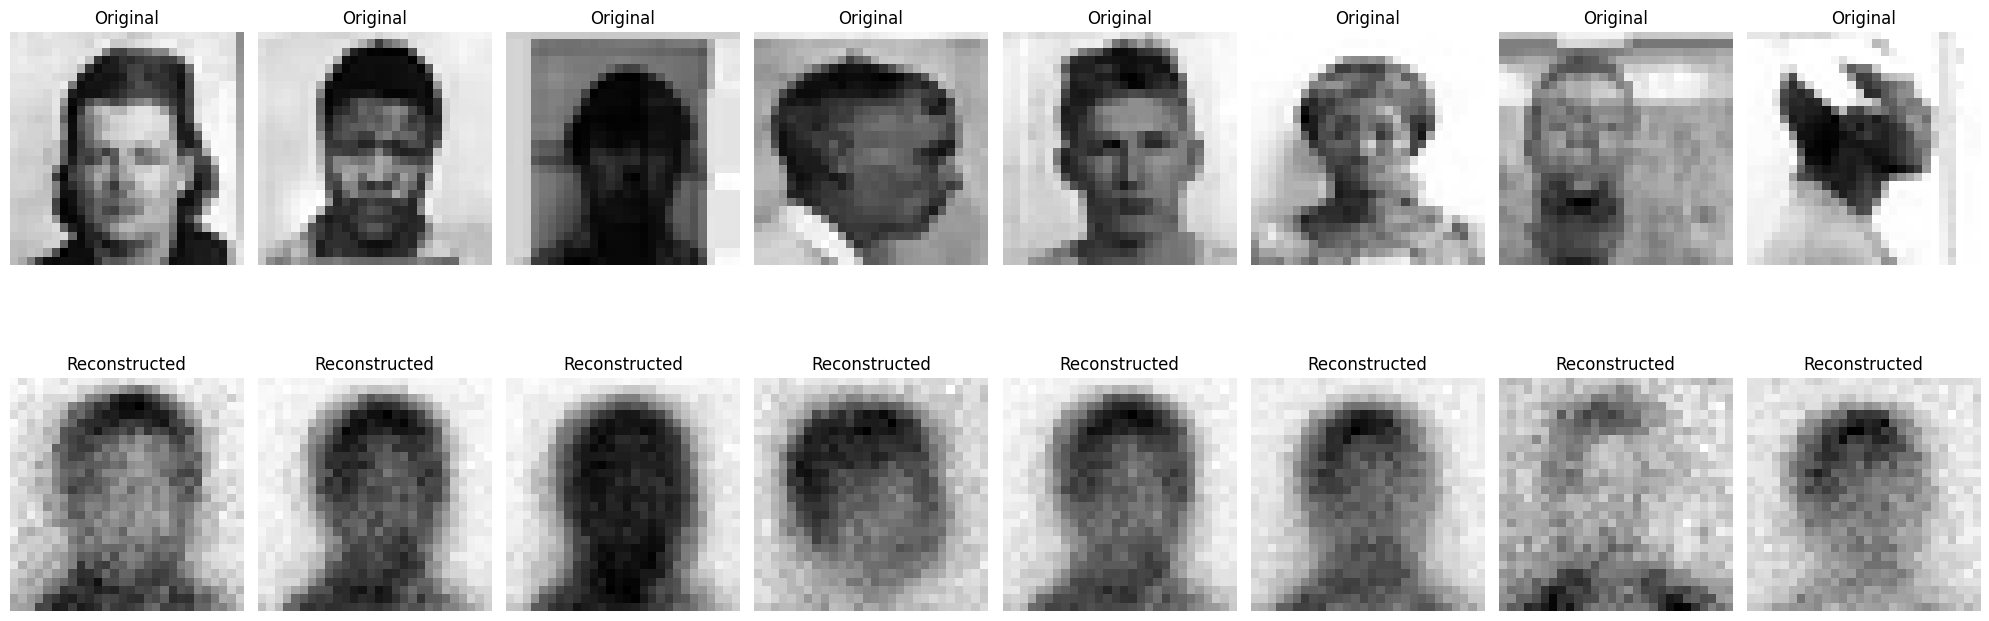

In [11]:
size = x_val.shape[0]
plt.figure(figsize=(20, 8))
for i in range(size):
        # Original
        plt.subplot(2, size, i + 1)
        plt.imshow(x_val[i], cmap='gray')
        plt.title("Original")
        plt.axis('off')

        # Reconstructed
        plt.subplot(2, size, i + 1 + size)
        plt.imshow(x_pred[i], cmap='gray')
        plt.title("Reconstructed")
        plt.axis('off')

plt.tight_layout()
plt.show()

# Stap 4: Outlier detection
## 4.1 Quanitificeer de verschillen
Vergelijk de verschillen in de afbeeldingen met verschillende performance metrics zoals MSE, RMSE, MAPE, 
gebruik hiervoor de module <b> sklearn.metrics

Kies eerst MSE om te kijken of er een significant verschill is met outliers en niet-outliers

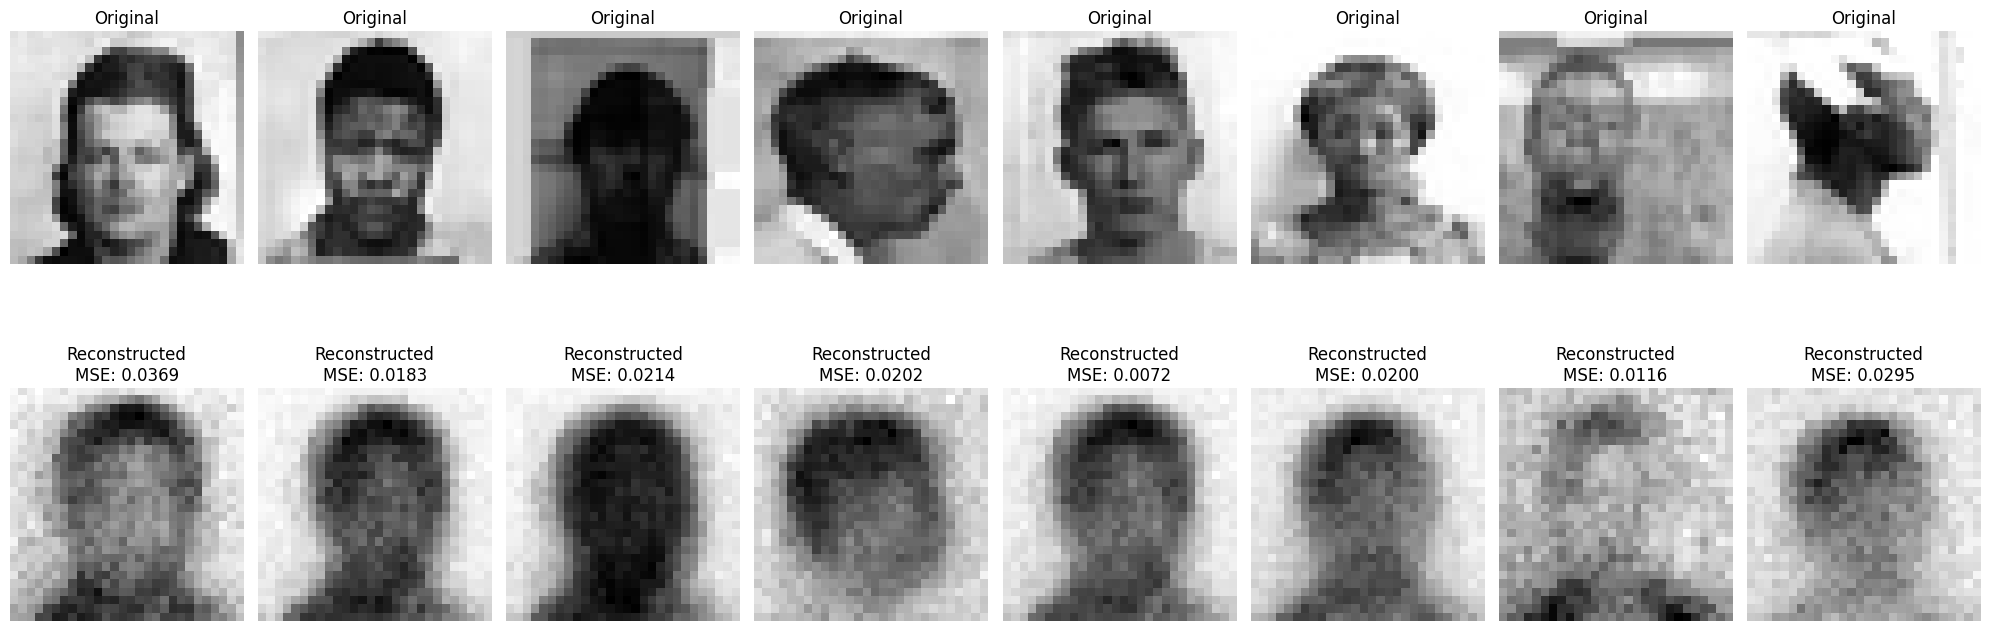

In [12]:
plt.figure(figsize=(20, 8))
for i in range(size):
        # Calculate MSE
        mse = mean_squared_error(x_val[i].flatten(), x_pred[i].flatten())

        # Original
        plt.subplot(2, size, i + 1)
        plt.imshow(x_val[i], cmap='gray')
        plt.title("Original")
        plt.axis('off')

        # Reconstructed
        plt.subplot(2, size, i + 1 + size)
        plt.imshow(x_pred[i], cmap='gray')
        plt.title(f"Reconstructed\nMSE: {mse:.4f}")
        plt.axis('off')

plt.tight_layout()
plt.show()

# 4.2 Tunen
Kan je alle outliers eruit halen op basis van de metrics? Gefeliciteerd
Mocht dit niet het geval zijn, dan kan dit aan de "latent_dim" liggen, de ruimte naar waar de afbeelding wordt samengeknepen in het model, speel met deze parameter en kijk of het de verschillen tussen de outliers en niet-outliers kan verbeteren.

## 4.3 Threshold
Als de vorige stappen goed werken wordt het tijd om automatisch aan te geven wat de outliers zijn.
Kies een threshold voor de door jouw gekozen performance metric.

In [13]:
reconstructed = model.predict(images)
mse_scores = [mean_squared_error(images[i].flatten() / 255, reconstructed[i].flatten() / 255)
              for i in range(images.shape[0])]

threshold = np.mean(mse_scores) + np.std(mse_scores)
threshold


36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


0.6094218187451164

In [14]:
outliers = []
inliers = []
for i in range(images.shape[0]):
    original = images[i] / 255
    pred = reconstructed[i] / 255
    mse_val = mean_squared_error(original.flatten(), pred.flatten())
    # print(mse_val)
    if mse_val > threshold:
        outliers.append(images[i])
    else :
        inliers.append(images[i])

In [15]:
outliers = np.stack(outliers)
inliers = np.stack(inliers)

In [16]:
x_val = np.concatenate((inliers[5:10], outliers[0:3])) / 255
x_pred = model.predict(x_val) / 255

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


# Opdracht voor volgende week
Maak een algoritme dat automatisch verteld of een afbeelding een anomally is op basis van jouw model.

Deel daarnaast mogelijke interessante bevindingen.

Iedereen mag even kort voor de groep presenteren

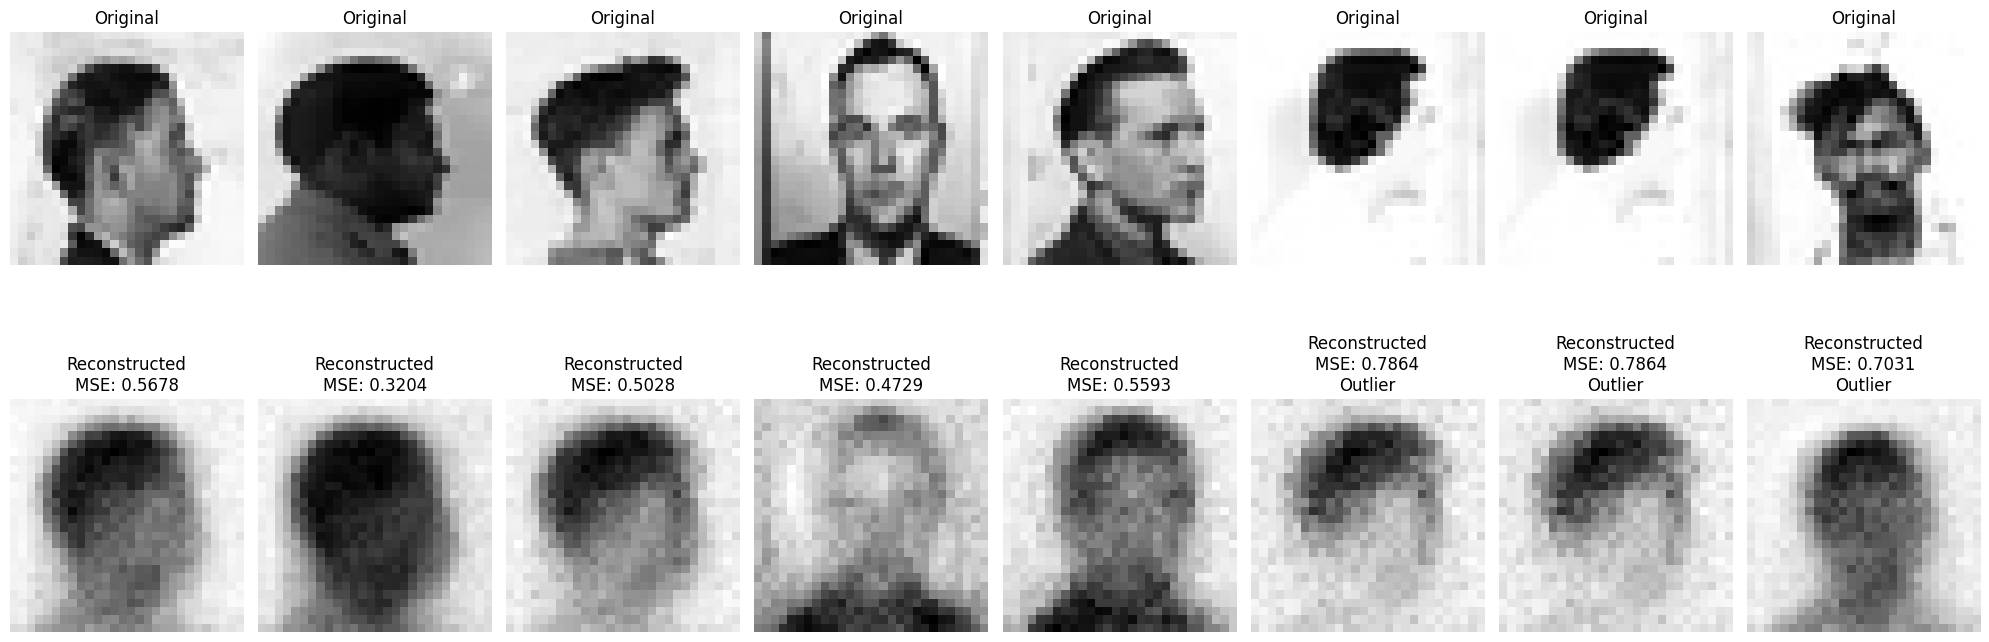

In [17]:
plt.figure(figsize=(20, 8))
size = x_val.shape[0]
for i in range(size):
        # Calculate MSE
        mse = mean_squared_error(x_val[i].flatten(), x_pred[i].flatten())

        # Original
        plt.subplot(2, size, i + 1)
        plt.imshow(x_val[i], cmap='gray')
        plt.title("Original")
        plt.axis('off')

        # Reconstructed
        plt.subplot(2, size, i + 1 + size)
        plt.imshow(x_pred[i], cmap='gray')
        if mse > threshold:
                plt.title(f"Reconstructed\nMSE: {mse:.4f}\nOutlier")
        else:
                plt.title(f"Reconstructed\nMSE: {mse:.4f}")
        plt.axis('off')

plt.tight_layout()
plt.show()

In [18]:
def custom_autoencoder(x_train, x_test, latent_dim, num_epochs):
    """
    :param x_train: this should be (around) 80% of your train dataset !!important, use a random split
    :param x_test: this should be (around) 20 % of your train dataset !!important, use a random split
    :param latent_dim: This is the space the images will be reduced to, to start: use the value 164, play with it later
    :param num_epochs: The number of training rounds
    :return: [0] : the trained autoencoder model
             [1] : the training data loss per epoch
             [2] : the test data loss per epoch
    """
    import tensorflow as tf
    from tensorflow.keras import layers, losses
    from tensorflow.keras.models import Model

    class Autoencoder(Model):
        def __init__(self, latent_dim):
            super(Autoencoder, self).__init__()
            self.latent_dim = latent_dim
            self.encoder = tf.keras.Sequential([
                layers.Flatten(input_shape=(28, 28)),
                layers.Dense(32, activation="relu"),
                layers.Dense(16, activation="relu"),
                layers.Dense(8, activation="relu"),
                layers.Dense(latent_dim, activation="relu")
            ])

            self.decoder = tf.keras.Sequential([
                layers.Dense(8, activation="relu"),
                layers.Dense(16, activation="relu"),
                layers.Dense(32, activation="relu"),
                layers.Dense(784, activation="sigmoid"),
                layers.Reshape((28, 28))
            ])

        def call(self, x):
            encoded = self.encoder(x)
            decoded = self.decoder(encoded)
            return decoded

    # Your model and training
    autoencoder = Autoencoder(latent_dim)

    autoencoder.compile(optimizer='adam', loss=losses.MeanSquaredError())

    history = autoencoder.fit(x_train, x_train,
                            epochs=num_epochs,
                            shuffle=True,
                            validation_data=(x_test, x_test))

    return autoencoder, history.history['loss'], history.history['val_loss']

In [19]:
custom_model, train_loss, test_loss = custom_autoencoder(x_train, x_test, 164, 150)

Epoch 1/150


c:\Users\chaos\anaconda3\Lib\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0824 - val_loss: 0.0471
Epoch 2/150
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0463 - val_loss: 0.0416
Epoch 3/150
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0429 - val_loss: 0.0405
Epoch 4/150
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0416 - val_loss: 0.0393
Epoch 5/150
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0417 - val_loss: 0.0388
Epoch 6/150
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0408 - val_loss: 0.0385
Epoch 7/150
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0395 - val_loss: 0.0379
Epoch 8/150
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0398 - val_loss: 0.0376
Epoch 9/150
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0391 - val_loss: 0.0369
Epoch 10/150
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0378 - val_loss: 0.0374
Epoch 11/150
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0363 - val_loss: 0.0325
Epoch 12/150
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0326 - val_lo

In [20]:
reconstructed = custom_model.predict(images)
mse_scores = [mean_squared_error(images[i].flatten() / 255, reconstructed[i].flatten() / 255)
              for i in range(images.shape[0])]

threshold = np.mean(mse_scores) + np.std(mse_scores)
threshold

36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


0.6088822211908916

In [21]:
x_val = np.concatenate((inliers[5:10], outliers[3:6])) / 255
x_pred = custom_model.predict(x_val) / 255

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


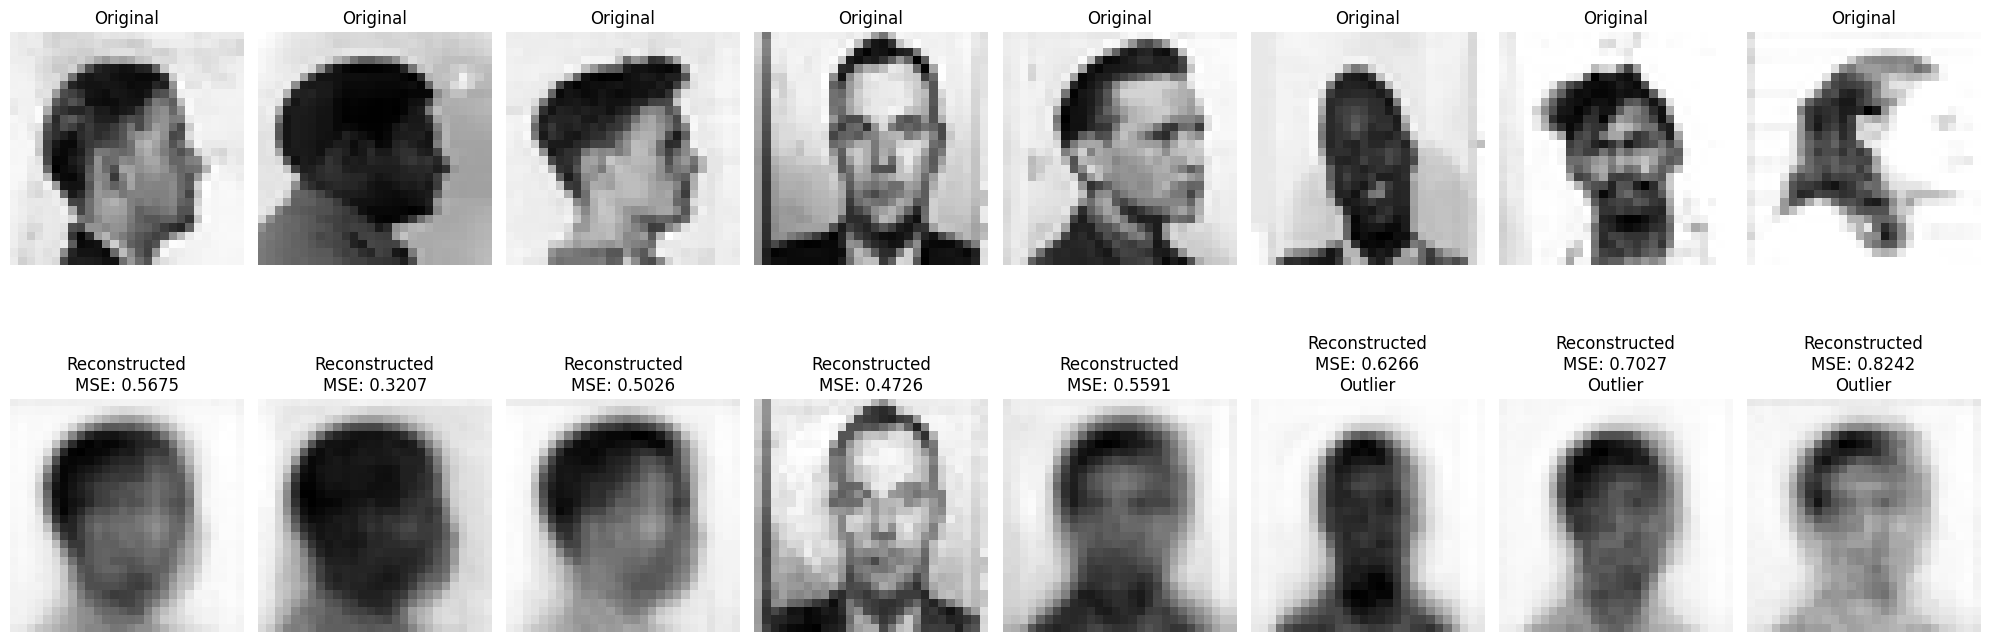

In [22]:
plt.figure(figsize=(20, 8))
size = x_val.shape[0]
for i in range(size):
        # Calculate MSE
        mse = mean_squared_error(x_val[i].flatten(), x_pred[i].flatten())

        # Original
        plt.subplot(2, size, i + 1)
        plt.imshow(x_val[i], cmap='gray')
        plt.title("Original")
        plt.axis('off')

        # Reconstructed
        plt.subplot(2, size, i + 1 + size)
        plt.imshow(x_pred[i], cmap='gray')
        if mse > threshold:
                plt.title(f"Reconstructed\nMSE: {mse:.4f}\nOutlier")
        else:
                plt.title(f"Reconstructed\nMSE: {mse:.4f}")
        plt.axis('off')

plt.tight_layout()
plt.show()

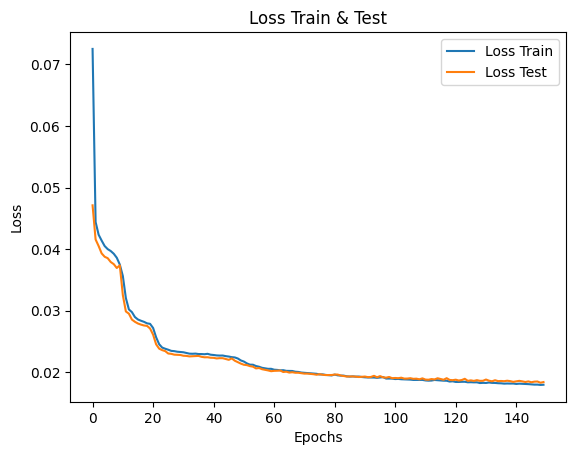

In [23]:
plt.plot(train_loss, label = "Loss Train")
plt.plot(test_loss, label = "Loss Test")
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss Train & Test")
plt.show()